# Species Distribution Modellin in Python

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geowombat as gw # remote sensing and spatial operations
import geopandas as gpd

# import dask
from dask.distributed import LocalCluster, Client
import joblib

import matplotlib.pyplot as plt
import os
import glob

In [4]:
%matplotlib inline

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38565")
client

<Client: 'tcp://127.0.0.1:38565' processes=4 threads=12, memory=12.03 GiB>

### *Listing raster layers*

In [6]:
rlist = glob.glob("Rasters/*.tif")
rlist

['Rasters/tempann.tif',
 'Rasters/vegsys.tif',
 'Rasters/solrad.tif',
 'Rasters/topo.tif',
 'Rasters/raindq.tif',
 'Rasters/cti.tif',
 'Rasters/mi.tif',
 'Rasters/soildepth.tif',
 'Rasters/rugged.tif',
 'Rasters/rainann.tif',
 'Rasters/soilfert.tif',
 'Rasters/tempmin.tif',
 'Rasters/disturb.tif']

In [7]:
names = [i[8:-4] for i in rlist]
names[0:3]

['tempann', 'vegsys', 'solrad']

### *Reading occurrence points*

In [8]:
# import point data
points = pd.read_csv("Records/train_po/NSWtrain_po.csv")
occ = points[points["spid"] == "nsw14"]
occ = occ[['occ', 'x', 'y']]
occ.shape

(315, 3)

In [9]:
geo_occ = gpd.GeoDataFrame(occ, geometry=gpd.points_from_xy(occ.x, occ.y))
geo_occ.head()

,occ,x,y,geometry
1149,1,153.4879,-28.1642,POINT (153.48790 -28.16420)
1150,1,153.4838,-28.1651,POINT (153.48380 -28.16510)
1151,1,153.4930,-28.1696,POINT (153.49300 -28.16960)
1152,1,152.5070,-28.2522,POINT (152.50700 -28.25220)
1153,1,152.4990,-28.2567,POINT (152.49900 -28.25670)


### *Generating random background samples*

In [10]:
from shapely.geometry import Point

def random_points_in_polygon(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds.values[0]
    x = np.random.uniform(minx, maxx, number)
    y = np.random.uniform(miny, maxy, number)
    
    df = pd.DataFrame()
    df['geometry'] = list(zip(x,y))
    df['geometry'] = df['geometry'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='geometry')
    
    Sjoin = gpd.tools.sjoin(gdf_points, polygon, predicate="within", how='left')

    # Keep points in "myPoly"
    pnts_in_poly = gdf_points[Sjoin.index_right==0]

    return pnts_in_poly

In [11]:
# read the border file
border = gpd.read_file("nsw.gpkg")

In [12]:
bg = random_points_in_polygon(border, 3_000)
bg.shape

(1544, 1)

In [13]:
bg['occ'] = 0
bg.head()

,geometry,occ
0,POINT (152.71517 -29.35785),0
1,POINT (151.28634 -32.41973),0
2,POINT (151.45939 -31.37968),0
3,POINT (152.62170 -29.07185),0
4,POINT (152.08615 -30.78675),0


<AxesSubplot:>

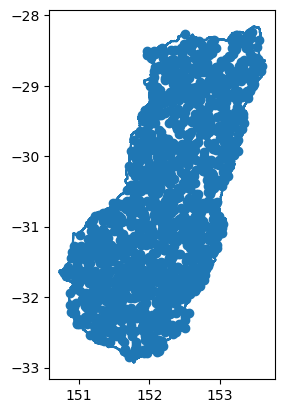

In [14]:
fig, ax = plt.subplots()

border.boundary.plot(ax=ax)
bg.plot(ax=ax)

### *Combine occurrence and background sample*

In [15]:
samples = pd.concat([geo_occ[['occ', 'geometry']], bg])
samples.head()

,occ,geometry
1149,1,POINT (153.48790 -28.16420)
1150,1,POINT (153.48380 -28.16510)
1151,1,POINT (153.49300 -28.16960)
1152,1,POINT (152.50700 -28.25220)
1153,1,POINT (152.49900 -28.25670)


In [16]:
samples.groupby('occ').count()

,geometry
occ,
0,1544
1,315


In [17]:
# save to file
samples.to_file('occurrence.gpkg', driver='GPKG', layer='name')

### *Extrating raster values for model training*

In [19]:
%%time
with gw.open(rlist, chunks=(1800, 1800)) as src:
    train_gdf = src.gw.extract('occurrence.gpkg', time_names=names, band_names=None)

CPU times: user 390 ms, sys: 12.5 ms, total: 402 ms
Wall time: 726 ms


In [20]:
train_gdf

,occ,geometry,id,tempann_1,vegsys_1,solrad_1,topo_1,raindq_1,cti_1,mi_1,soildepth_1,rugged_1,rainann_1,soilfert_1,tempmin_1,disturb_1
0,1,POINT (153.48790 -28.16420),0,200,5,89,-1,216,1339,88,1139,11,1590,2,85,3
1,1,POINT (153.48380 -28.16510),1,199,5,89,-3,216,1439,88,1149,15,1592,2,84,3
2,1,POINT (153.49300 -28.16960),2,200,5,89,-1,222,1629,89,1159,1,1594,2,86,3
3,1,POINT (152.50700 -28.25220),3,159,2,86,-3,222,1259,92,1080,28,1580,2,45,2
4,1,POINT (152.49900 -28.25670),4,158,2,88,-3,222,1279,91,1110,51,1568,2,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,0,POINT (152.22393 -29.36927),1854,145,3,72,40,210,1059,89,910,96,1456,2,7,3
1855,0,POINT (151.77943 -32.00609),1855,173,7,87,-3,138,1259,75,959,58,1088,2,57,3
1856,0,POINT (152.10343 -28.75717),1856,141,2,92,-5,174,1549,74,1009,15,992,2,14,3
1857,0,POINT (152.54154 -30.45089),1857,155,2,81,39,234,1059,90,1029,102,1690,2,19,1


<AxesSubplot:>

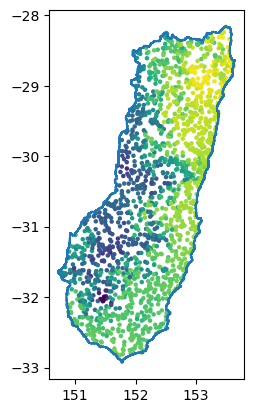

In [21]:
base = border.boundary.plot()
train_gdf.plot(ax=base, column='tempann_1', markersize=5)

In [22]:
# select a few variables and rename them
train_df = train_gdf[['tempann_1', 'solrad_1', 'topo_1', 'raindq_1', 'cti_1', 'mi_1', 'soildepth_1', 'rugged_1', 'rainann_1', 'soilfert_1', 'tempmin_1']]
col_names = {i:i[0:-2] for i in train_df.columns}
X = train_df.rename(columns=col_names)
X.head()

,tempann,solrad,topo,raindq,cti,mi,soildepth,rugged,rainann,soilfert,tempmin
0,200,89,-1,216,1339,88,1139,11,1590,2,85
1,199,89,-3,216,1439,88,1149,15,1592,2,84
2,200,89,-1,222,1629,89,1159,1,1594,2,86
3,159,86,-3,222,1259,92,1080,28,1580,2,45
4,158,88,-3,222,1279,91,1110,51,1568,2,44


In [23]:
y = train_gdf['occ']
y.unique()

array([1, 0])

### *Model fitting*

In [24]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [25]:
rf_model = RandomForestClassifier()

In [26]:
cv = StratifiedKFold(n_splits=5)

In [27]:
np.floor(np.sqrt(X.shape[1]))

3.0

In [28]:
params = {'max_features': [2, 3, 4, 5], 
          'n_estimators':[500, 1000],
          'class_weight':['balanced']}

In [29]:
gridsearch = GridSearchCV(rf_model, cv=cv, scoring='roc_auc', param_grid=params, n_jobs=4, verbose=1)

In [30]:
%%time
gridsearch.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: user 986 ms, sys: 135 ms, total: 1.12 s
Wall time: 26.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'class_weight': ['balanced'],
                         'max_features': [2, 3, 4, 5],
                         'n_estimators': [500, 1000]},
             scoring='roc_auc', verbose=1)

In [31]:
gridsearch.best_estimator_

RandomForestClassifier(class_weight='balanced', max_features=2,
                       n_estimators=500)

In [32]:
gridsearch.best_score_

0.8063284252604642

In [33]:
# predict on the training samples
train_predicted = gridsearch.predict_proba(X)
train_predicted.shape

(1859, 2)

In [34]:
train_predicted

array([[0.094, 0.906],
       [0.09 , 0.91 ],
       [0.196, 0.804],
       ...,
       [0.998, 0.002],
       [0.89 , 0.11 ],
       [0.988, 0.012]])

In [35]:
train_gdf['prediction'] = train_predicted[:,1]

<AxesSubplot:>

<Figure size 200x200 with 0 Axes>

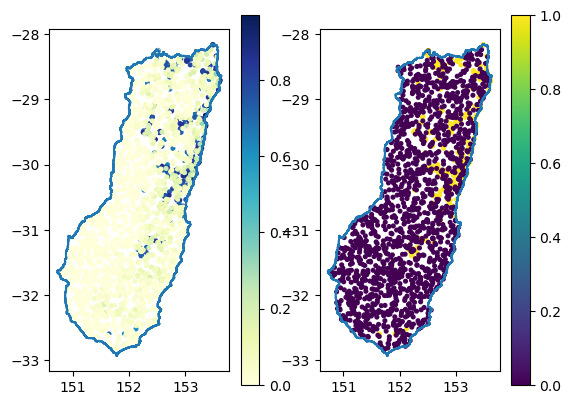

In [36]:
plt.figure(figsize=(2,2))
fig, (ax1, ax2) = plt.subplots(1,2)

base = border.boundary.plot(ax=ax1)
train_gdf.plot(ax=base, column='prediction', markersize=7, cmap='YlGnBu', legend=True)

base = border.boundary.plot(ax=ax2)
train_gdf.plot(ax=base, column='occ', markersize=7, legend=True)

### *Predicting to an xarray*

In [37]:
names

['tempann',
 'vegsys',
 'solrad',
 'topo',
 'raindq',
 'cti',
 'mi',
 'soildepth',
 'rugged',
 'rainann',
 'soilfert',
 'tempmin',
 'disturb']

In [38]:
name_var = xr.Variable('name', names)
r = xr.concat([rxr.open_rasterio(i, chunks={'x':900, 'y':900}) for i in rlist], dim=name_var)
r = r.to_dataset('name').squeeze() # drop unused dimention
r

<xarray.Dataset>
Dimensions:      (y: 5390, x: 3378)
Coordinates:
    band         int64 1
  * x            (x) float64 150.6 150.7 150.7 150.7 ... 153.7 153.7 153.7 153.7
  * y            (y) float64 -28.1 -28.1 -28.1 -28.11 ... -32.95 -32.95 -32.95
    spatial_ref  int64 0
Data variables: (12/13)
    tempann      (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    vegsys       (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    solrad       (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    topo         (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    raindq       (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    cti          (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    ...           ...
    soildepth    (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    rugged       (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    rainann      (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    soilfert     (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    tempmin      (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
    disturb      (y, x) int32 dask.array<chunksize=(900, 900), meta=np.ndarray>
Attributes:
    STATISTICS_MAXIMUM:  201
    STATISTICS_MEAN:     159.29271255618
    STATISTICS_MINIMUM:  84
    STATISTICS_STDDEV:   25.150546185294
    _FillValue:          255.0
    scale_factor:        1.0
    add_offset:          0.0

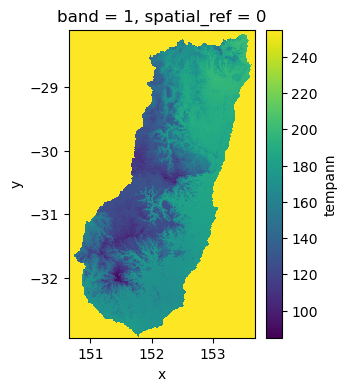

In [39]:
plt.figure(figsize=(3,4))
r.tempann[0::10, 0::10].plot()

In [40]:
dask_df = r.to_dask_dataframe()

In [41]:
list(X.columns)

['tempann',
 'solrad',
 'topo',
 'raindq',
 'cti',
 'mi',
 'soildepth',
 'rugged',
 'rainann',
 'soilfert',
 'tempmin']

In [43]:
Xr = dask_df[list(X.columns)]
Xr

,tempann,solrad,topo,raindq,cti,mi,soildepth,rugged,rainann,soilfert,tempmin
npartitions=24,,,,,,,,,,,
0,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32
760050,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
17450748,...,...,...,...,...,...,...,...,...,...,...
18207419,...,...,...,...,...,...,...,...,...,...,...


In [44]:
%%time
# predict to dask dataframe of the rasters
with joblib.parallel_backend('dask', scatter=[Xr]):
    raster_pred = gridsearch.predict_proba(Xr)

CPU times: user 24min 30s, sys: 4min 36s, total: 29min 6s
Wall time: 4min 21s


In [45]:
raster_pred.shape, r.tempann.shape

((18207420, 2), (5390, 3378))

In [46]:
raster_pred[:,1]

array([0.274, 0.274, 0.274, ..., 0.274, 0.274, 0.274])

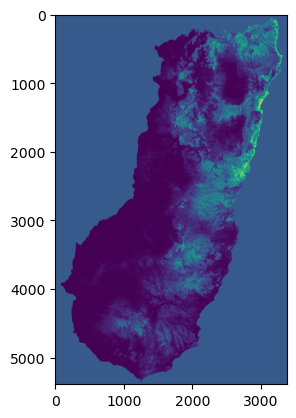

In [47]:
plt.imshow(raster_pred[:,1].reshape(r.tempann.shape))

## *Model with ParallelPosit?*

## Modelling test with GeoWombat

In [12]:
from geowombat.ml import fit, predict, fit_predict

In [13]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn_xarray.model_selection import CrossValidatorWrapper
from sklearn.pipeline import make_pipeline

In [21]:
selected_vars = ['Rasters/tempann.tif',
                 'Rasters/solrad.tif',
                 'Rasters/raindq.tif',
                 'Rasters/mi.tif',
                 'Rasters/soildepth.tif',
                 'Rasters/rugged.tif',
                 'Rasters/rainann.tif',
                 'Rasters/soilfert.tif',
                 'Rasters/tempmin.tif']

In [39]:
samples = samples.set_crs('epsg:4326')

In [41]:
samples.crs# is None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
%%time
with gw.open(selected_vars, chunks=(1800, 1800)) as src:
    y = fit_predict(src, model_pipeline, samples, col='occ')
    print(y)

In [ ]:
# close the cluster
client.close()
cluster.close()